# Importing packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# I. Centering step

### Functions for gradient and hessian computation

In [65]:
def compute_gradient_ft(t, x, Q, p, A ,b):
    # t the scalar that charachterises the functionn we are trying to minimise
    # x of dimension (n), the point in which we are evaluating the function
    # Q of dimension (n,n)
    # p of dimenson (n)
    # A of dimension (m,n)
    # b of dimension (m)

    m = b.size
    n = x.size
    left_side = t*(2*Q @ x + p)
    right_side = np.zeros(n)
    for i in range (m):
    #     print((b[i] - A[i] @ x).shape)
    #     print(f"A shape: {A.shape}")
    #     print(f"x shape: {x.shape}")
    #     print(f"b shape: {b.shape}")
        right_side += A[i]  / (b[i] - A[i] @ x)



    return left_side + right_side 


def compute_hessian_ft(t, x, Q, A, b):
    # t the scalar that charachterises the functionn we are trying to minimise
    # x of dimension (n), the point in which we are evaluating the function
    # Q of dimension (n,n)
    # A of dimension (m,n)
    # b of dimension (m)
    
    m = b.size
    n = x.size
    left_side = 2 * t * Q
    right_side = np.zeros((n,n))
    for i in range(m):
        right_side += (np.outer(A[i], A[i]) ) / (b[i] - A[i]  @ x)**2

    return left_side + right_side


def compute_gradient_ft(t, x, Q, p, A, b):
    s = b - A @ x                  # shape (m,)
    return t * (2 * Q @ x + p) + A.T @ (1 / s)

def compute_hessian_ft(t, x, Q, A, b):
    s = b - A @ x                  # shape (m,)
    w = 1 / s**2                   # shape (m,)
    return 2 * t * Q + A.T @ (A * w[:, None])


# n = 10
# m = 4
# t = 1
# x = np.random.randn(n)
# Q = np.random.randn(n,n)
# p = np.random.randn(n)
# A = np.random.randn(m,n)
# b = np.random.randn(m)

# compute_gradient_ft(t, x, Q, p, A ,b)
# compute_hessian_ft(t, x, Q, A, b)


In [66]:
# def ft(x):
#     s = b - A @ x           
#     if np.any(s <= 0):  # value at +infinity if out of bounds
#         return np.inf

#     right_side = t * (x @ Q @ x + p @ x)
#     left_side  = -np.sum(np.log(s))
#     return right_side + left_side

# ft(x)

### Additonal utility functions

In [67]:
def compute_delta_x(grad, hessian):
    return np.linalg.solve(hessian, -grad)

def backtracking(ft, x, delta_x, grad, alpha, beta): # returns the optimal x considering backtracking, not the optimal step
    # x of shape (n)
    # delta_x of shape (n)
    # grad of shape (n)
    step = 1
    while ft(x + step * delta_x) >= ft(x) + alpha * step * grad @ delta_x:
        step = beta * step
    print(step)
    return x + step * delta_x


In [68]:
# n = 10
# m = 4
# t = 1

# x = np.random.randn(n)        
# Q  = np.random.randn(n, n)
# A  = np.random.randn(m, n)

# slack = np.random.rand(m) + 0.5  # strictly positive slack 
# b = A @ x + slack               # so that b - A x0 = slack > 0

# alpha = 0.3
# beta = 0.5

# grad = compute_gradient_ft(t, x, Q, p, A ,b)
# hessian = compute_hessian_ft(t, x, Q, A, b)
# delta_x = compute_delta_x(grad, hessian)

# backtracking(ft, x, delta_x, grad, alpha, beta)




In [69]:
def newton_dercrement(grad, delta_x, eps):
    return - grad @ delta_x/ 2 <= eps

def compute_delta_x(grad, hessian):
    return np.linalg.solve(hessian, -grad)

def backtracking(ft, x, delta_x, grad, alpha, beta): # returns the optimal x considering backtracking, not the optimal step
    # x of shape (n)
    # delta_x of shape (n)
    # grad of shape (n)
    step = 1
    while ft(x + step * delta_x) >= ft(x) + alpha * step * grad @ delta_x:
        step = beta * step
    return x + step * delta_x



# # dimensions
# n = 10
# d = 2

# #LASSO hyperprameter
# lambda_val = 10

# # primal matrix sampling
# X = np.random.randn(n, d)
# y = np.random.randn(n)

# # dual variables reformating
# Q  = np.eye(n) / 2
# p = -y
# A = np.concatenate([X.T, - X.T], axis=0)
# b = lambda_val * np.ones(2 * d)

# # interior points and Newton hyperparametres
# alpha = 0.3
# beta = 0.5
# v0 = np.zeros(n)
# eps_newton = 0.0001

# t = 1
# return_array = centering_step(Q, p, A, b, t, v0, eps_newton)


### Centring step function

In [70]:

def centering_step(Q, p, A, b, t, v0, eps):
    v_running = v0
    list_v_points = []
    count = 0
    while True:
        grad = compute_gradient_ft(t, v_running, Q, p, A ,b)
        hessian = compute_hessian_ft(t, v_running, Q, A, b)
        delta_v = compute_delta_x(grad, hessian)

        if newton_dercrement(grad, delta_v, eps) and count > 0:
            break

        
        def ft(x):
            s = b - A @ x           
            if np.any(s <= 0):  # value at +infinity if out of bounds
                return np.inf

            right_side = t * (x @ Q @ x + p @ x)
            left_side  = -np.sum(np.log(s))
            return right_side + left_side
        
        alpha = 0.3
        beta = 0.5
        v_running = backtracking(ft, v_running, delta_v, grad, alpha, beta)
        list_v_points.append(v_running)
        count += 1
    return list_v_points

# dimensions
n = 10
d = 2

#LASSO hyperprameter
lambda_val = 10

# primal matrix sampling
X = np.random.randn(n, d)
y = np.random.randn(n)

# dual variables reformating
Q  = np.eye(n) / 2
p = -y
A = np.concatenate([X.T, - X.T], axis=0)
b = lambda_val * np.ones(2 * d)

# interior points and Newton hyperparametres
v0 = np.zeros(n)
eps_newton = 0.01

t = 1
return_array = centering_step(Q, p, A, b, t, v0, eps_newton)


# Log-barrier method (interior points)

In [71]:
def barr_method(Q, p, A, b, v0, eps_barr=0.1, eps_newton=0.1, mu = 1.2):
    m = b.size
    eps_newton = eps_newton
    t = 1

    list_v_barr = [v0]
    v_running = centering_step(Q, p, A, b, t, v0, eps_newton)[-1]
    list_v_barr.append(v_running)

    while eps_barr <= m / t:
        t = mu * t
        v_running = centering_step(Q, p, A, b, t, v0, eps_newton)[-1]
        list_v_barr.append(v_running)

    return list_v_barr
    
# dimensions
n = 100
d = 30

#LASSO hyperprameter
lambda_val = 10

def generate_variables(n, d, lambda_val):
    # primal matrix sampling
    X = np.random.randn(n, d)
    y = np.random.randn(n)

    # dual variables reformating
    Q  = np.eye(n) / 2
    p = -y
    A = np.concatenate([X.T, - X.T], axis=0)
    b = lambda_val * np.ones(2 * d)

    v0 = np.zeros(n)

    return Q, p, A, b, v0


Q, p, A, b, v0= generate_variables(n, d, lambda_val)

# interior points and Newton hyperparametres

eps_barr = 0.1
mu = 1.2

list_v_barr = barr_method(Q, p, A, b, v0, eps_barr=eps_barr, mu=mu)
print(list_v_barr)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([ 0.84438291, -0.55418418,  0.87606601,  0.39884464,  0.01933569,
        0.24265227,  0.17919921,  0.54403833, -0.11924397, -0.65097733,
       -0.357882  ,  0.1662048 , -1.1321273 ,  0.19556239,  0.61067482,
        1.36689845, -0.68247532, -0.90157356, -1.20998896,  0.27474643,
       -0.15497104, -1.52081911, -0.00529839, -1.18666471, -0.21205731,
       -1.06114651,  0.6412802 ,  0.72538145,  0.61595885, -0.63842626,
        0.02350874,  0.09905537,  1.55559123, -1.28807308,  1.11940591,
       -0.96377233,  0.47095222, -1.00129888,  0.63

In [72]:
import cvxpy as cp
import numpy as np

def solve_qp(Q, p, A, b):
    x = cp.Variable(Q.shape[0])
    prob = cp.Problem(cp.Minimize(cp.quad_form(x, Q) + p @ x), [A @ x <= b])
    prob.solve()
    return x.value, prob.value

solve_qp(Q, p, A, b)

(array([ 7.53540323e-01, -1.04668584e-01,  5.04974476e-01,  7.70458332e-01,
         2.32571532e-01,  2.49776140e-01,  3.96414616e-01,  6.54117140e-01,
        -3.03047832e-01, -8.33898207e-01, -5.18893914e-01,  5.60699157e-02,
        -1.40516474e+00, -1.40301402e-01,  7.00080330e-01,  1.72179305e+00,
        -4.73056421e-01, -7.05867785e-01, -1.05271605e+00,  5.11777048e-01,
        -4.11099804e-01, -1.41286159e+00, -2.16437540e-01, -1.47017706e+00,
        -1.26861426e-02, -8.95921780e-01,  4.94264120e-01,  9.93725092e-01,
         3.85089001e-01, -7.16798623e-01,  1.77491803e-01,  1.44630345e-01,
         1.45649977e+00, -1.45539933e+00,  1.21296380e+00, -9.83058068e-01,
         2.47917470e-02, -8.46184037e-01,  1.19362981e+00, -1.54213417e+00,
        -9.22965967e-02, -5.70138190e-01, -1.53190754e+00,  2.20435085e-01,
         5.17474079e-01,  9.73686842e-01, -1.46569791e+00, -2.02585423e+00,
        -5.72885562e-02,  1.07867476e+00, -7.73000787e-02, -1.09983082e+00,
         2.1

In [36]:

def f(x, Q, p): 
    return x @ Q @ x + p @ x

f(list_v_barr[-1], Q, p)

np.float64(-34.923373974505346)

# Running and plotting results

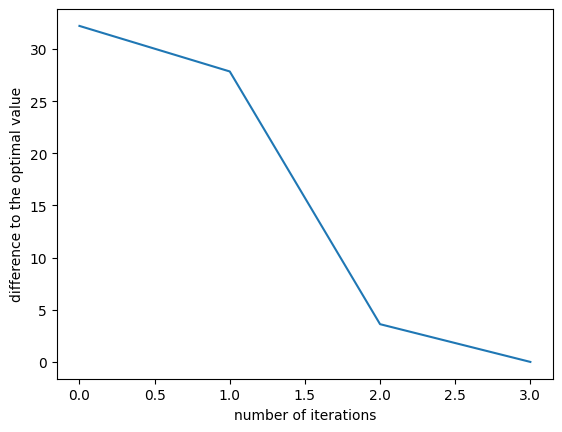

In [78]:
n = 100
d = int(1e3)

#LASSO hyperprameter
lambda_val = 10

# Generating the variables
Q, p, A, b,v0 = generate_variables(n, d, lambda_val)

# interior points and Newton hyperparametres
eps_barr = 5
eps_newton = 5
mu = 25

list_v_barr = barr_method(Q, p, A, b, v0, eps_barr=eps_barr, eps_newton=eps_newton, mu=mu)



def plot_results(Q, p, list_v_barr):
          
    def f(x, Q, p): 
        return x @ Q @ x + p @ x

    f_opt = f(list_v_barr[-1], Q, p)
    f_diff = [f(v,Q,p) - f_opt for v in list_v_barr]

    plt.plot(range(len(f_diff)), f_diff)
    plt.xlabel("number of iterations")
    plt.ylabel("difference to the optimal value")


plot_results(Q, p, list_v_barr)



In [92]:
def plot_grid(n, d, mu):
    n_columns = 3

    fig, axs = plt.subplots(1, n_columns, figsize=(18,4))
    axs = axs.flatten()

    # left subplot: your original plot
    for i in range(n_columns):
        Q, p, A, b,v0 = generate_variables(n, d, lambda_val)
        list_v_barr = barr_method(Q, p, A, b, v0, eps_barr=eps_barr, eps_newton=eps_newton, mu=mu)
        plot_results(Q, p, list_v_barr, ax=axs[i])

    fig.suptitle(f"Plot with n={n}, d={d} and mu={mu}", fontsize=16)
    plt.show()


def plot_all_in_one(n, d, mus):
    fig, ax = plt.subplots(figsize=(7,5))

    for mu in mus:
        Q, p, A, b, v0 = generate_variables(n, d, lambda_val)
        list_v_barr = barr_method(Q, p, A, b, v0,
                                  eps_barr=eps_barr,
                                  eps_newton=eps_newton,
                                  mu=mu)

        f_opt = f(list_v_barr[-1], Q, p)
        f_diff = [f(v, Q, p) - f_opt for v in list_v_barr]

        ax.plot(range(len(f_diff)), f_diff, label=f"mu={mu}")

    ax.set_title(f"n={n}, d={d}")
    ax.set_xlabel("number of iterations")
    ax.set_ylabel("difference to the optimal value")
    ax.legend()
    plt.show()


def f(x, Q, p):
    return x @ Q @ x + p @ x


def plot_all_in_one(n, d, mus):
    fig, (ax_traj, ax_mat) = plt.subplots(1, 2, figsize=(12, 5))

    final_vectors = []  # store list_v_barr[-1] for each mu

    # left: convergence curves
    for mu in mus:
        Q, p, A, b, v0 = generate_variables(n, d, lambda_val)
        list_v_barr = barr_method(Q, p, A, b, v0,
                                  eps_barr=eps_barr,
                                  eps_newton=eps_newton,
                                  mu=mu)

        x_final = list_v_barr[-1]
        final_vectors.append(x_final)

        f_opt = f(x_final, Q, p)
        f_diff = [f(v, Q, p) - f_opt for v in list_v_barr]
        ax_traj.plot(f_diff, label=f"mu={mu}")

    ax_traj.set_title(f"Convergence (n={n}, d={d})")
    ax_traj.set_xlabel("iterations")
    ax_traj.set_ylabel("distance to f_opt")
    ax_traj.legend()

    # right: MSE matrix between final vectors
    X = np.vstack(final_vectors)              # shape (k, d)
    diffs = X[:, None, :] - X[None, :, :]     # shape (k, k, d)
    mse_mat = np.mean(diffs**2, axis=2)       # shape (k, k)

    im = ax_mat.imshow(mse_mat, interpolation='nearest')
    plt.colorbar(im, ax=ax_mat)
    ax_mat.set_title("MSE between final solution vectors")
    ax_mat.set_xticks(range(len(mus)))
    ax_mat.set_yticks(range(len(mus)))
    ax_mat.set_xticklabels(mus)
    ax_mat.set_yticklabels(mus)
    ax_mat.set_xlabel("mu")
    ax_mat.set_ylabel("mu")

    plt.tight_layout()
    plt.show()


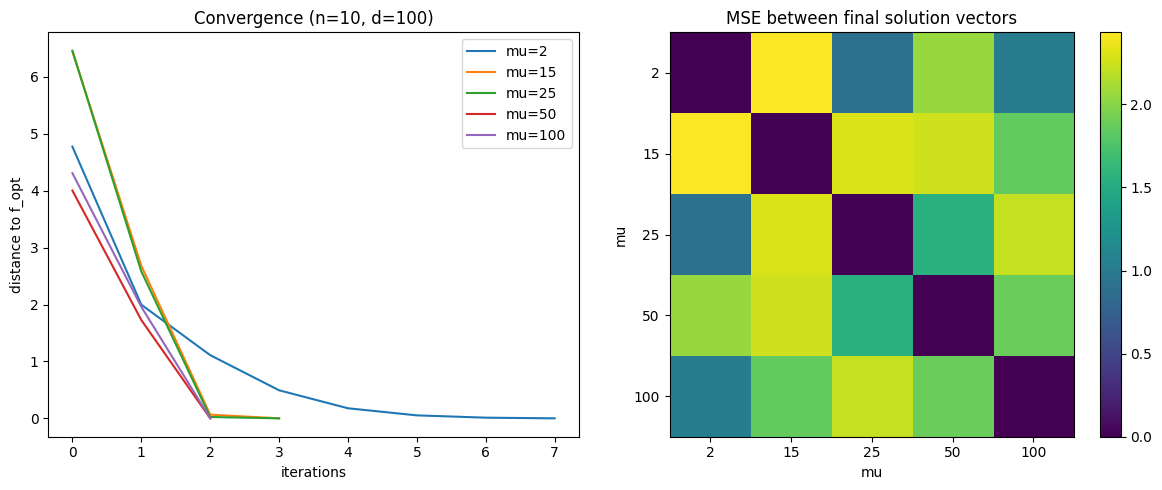

In [93]:
n = 10
d = int(1e2)
mu_list = [2, 15, 25, 50, 100]
plot_all_in_one(n, d, mu_list)

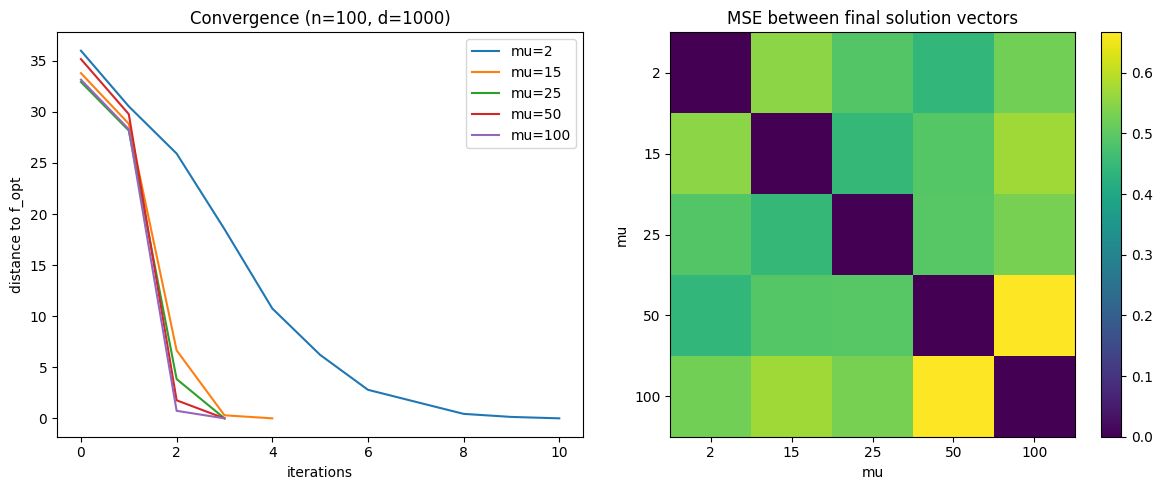

In [94]:
n = 100
d = int(1e3)
mu_list = [2, 15, 25, 50, 100]
plot_all_in_one(n, d, mu_list)

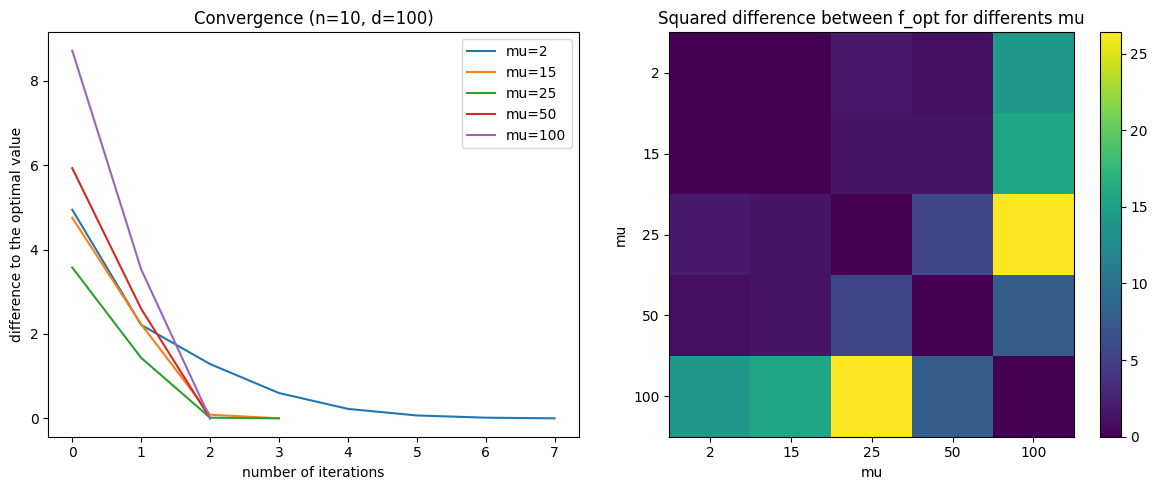

In [ ]:


# usage example
n = 10
d = int(1e2)
plot_all_in_one(n, d, [2, 15, 25, 50, 100])


**observation**: increasing $\mu$ reduces the number of iterations and, considering the high-dimension $w$ is in, the mse between ($w_{\mu}$) is small. So a high value of $\mu$ like 50 or 100 should be selected so as to have fewer steps and faster computation.